In [1]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset, AdultDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

from IPython.display import Markdown, display

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import json
from collections import OrderedDict
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

Import error: No module named 'tensorflow'


In [2]:
dataset_orig_adult = dataset_orig = AdultDataset(protected_attribute_names=['sex'], privileged_classes=[['Male']], features_to_drop=['fnlwgt','race'])

# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig_adult.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_adult.favorable_label, dataset_orig_adult.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_adult.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_adult.privileged_protected_attributes, dataset_orig_adult.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_adult.feature_names)


#### Dataset shape

(45222, 97)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Handlers-cleaners', 'oc

#### 10 different train test splits

In [3]:
# dataset_orig_train, dataset_orig_test = dataset_orig_adult.split([0.7], shuffle=True)
dataset_orig_train = {}
dataset_orig_test = {}

for i in range(0,10):
    dataset_orig_train[i], dataset_orig_test[i] = dataset_orig_adult.split([0.7], shuffle=True)
    

#### Test for disparate impact values for each train and test split

##### male is the priviledged class in Adult dataset

In [7]:
# Define privileged and unprivileged groups
priv = [{'sex': 1}] # Male
unpriv = [{'sex': 0}] # Female

In [8]:
for i in range(0,10):
    metric_otr = BinaryLabelDatasetMetric( dataset_orig_train[i],
    unprivileged_groups=unpriv, privileged_groups=priv)
    
    print("Disparate Impact value for original train split {} is: ".format(i), metric_otr.disparate_impact())

Disparate Impact value for original train split 0 is:  0.3590734381551717
Disparate Impact value for original train split 1 is:  0.36555341398386365
Disparate Impact value for original train split 2 is:  0.36602739207697665
Disparate Impact value for original train split 3 is:  0.3623196394066896
Disparate Impact value for original train split 4 is:  0.3751516897281327
Disparate Impact value for original train split 5 is:  0.3667986584778149
Disparate Impact value for original train split 6 is:  0.36139067323102836
Disparate Impact value for original train split 7 is:  0.36269775288580913
Disparate Impact value for original train split 8 is:  0.3579162764454635
Disparate Impact value for original train split 9 is:  0.36885186312405505


In [9]:
for i in range(0,10):
    metric_otr = BinaryLabelDatasetMetric( dataset_orig_test[i],
    unprivileged_groups=unpriv, privileged_groups=priv)
    
    print("Disparate Impact value for original test split {} is: ".format(i), metric_otr.disparate_impact())

Disparate Impact value for original test split 0 is:  0.37370654743521686
Disparate Impact value for original test split 1 is:  0.35867181825529787
Disparate Impact value for original test split 2 is:  0.357563195269274
Disparate Impact value for original test split 3 is:  0.3658809253350598
Disparate Impact value for original test split 4 is:  0.3353650256720024
Disparate Impact value for original test split 5 is:  0.3558368851467955
Disparate Impact value for original test split 6 is:  0.36837676009318887
Disparate Impact value for original test split 7 is:  0.3652876392123058
Disparate Impact value for original test split 8 is:  0.37644110582347223
Disparate Impact value for original test split 9 is:  0.3512083680180503


#### Now we will use DiparateImpactRemover Algo to mitigate this bias

In [11]:
# Create the algorithm object
# repair_level=1.0 means we want to maximise fairness.
di = DisparateImpactRemover(repair_level=1.0)

In [12]:
dataset_orig_train_transf = {}
dataset_orig_test_transf = {}

for i in range(0,10):
    dataset_orig_train_transf[i] = di.fit_transform(dataset_orig_train[i])
    dataset_orig_test_transf[i] = di.fit_transform(dataset_orig_test[i])

#### Now we will fit a Logistic Regression Classifier on this repaired dataset and obtain predictions

In [13]:
protected = 'sex'
index = dataset_orig_train_transf[0].feature_names.index(protected)

In [14]:
dataset_orig_test_transf_pred = {}
adult_disparateImpactRemover_disparate_impact = {}
adult_disparateImpactRemover_accuracy = {}
adult_disparateImpactRemover_CV = {}


for i in range(0, 10):
    X_tr = np.delete(dataset_orig_train_transf[i].features, index, axis=1)
    X_te = np.delete(dataset_orig_test_transf[i].features, index, axis=1)
    y_tr = dataset_orig_train_transf[i].labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    dataset_orig_test_transf_pred[i] = dataset_orig_test_transf[i].copy()
    dataset_orig_test_transf_pred[i].labels = lmod.predict(X_te)
    
    
    metric_otr_classification = ClassificationMetric(dataset_orig_test_transf[i], dataset_orig_test_transf_pred[i], unprivileged_groups=unpriv, privileged_groups=priv)
    
    adult_disparateImpactRemover_disparate_impact[i] = metric_otr_classification.disparate_impact()
    adult_disparateImpactRemover_accuracy[i] = metric_otr_classification.accuracy()
    adult_disparateImpactRemover_CV[i] = 1 - (-(metric_otr_classification.statistical_parity_difference()))


##### there is a small change in the DI values of the repaired test predictions dataset

In [15]:
adult_disparateImpactRemover_disparate_impact

{0: 0.3320270796735709,
 1: 0.3511274823295262,
 2: 0.31635132225061174,
 3: 0.34867639919708904,
 4: 0.29535070469132535,
 5: 0.358985489605624,
 6: 0.3536987028507118,
 7: 0.3271213447974777,
 8: 0.3530601544147908,
 9: 0.32765462115313854}

#### Now we can plot to see how the trade-off between fairness and accuracy changes when we use different input splits
#### For fairness we are using CV measure and for accuracy we are using the generic accuracy measure

Goal 1

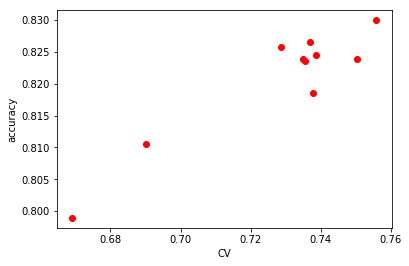

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(list(adult_disparateImpactRemover_CV.values()), list(adult_disparateImpactRemover_accuracy.values()), 'ro')
plt.ylabel('accuracy')
plt.xlabel('CV')
plt.show()

### Now on the same above dataset, let's apply another bias mitigation algorithm and compare the end results with the above results

#### Now we will apply a post-processing algorithm to the above dataset. 

We would want to use the exact same dataset with the exact same split to be sure that nothing changed on the input side.

We want to be able to compare 2 bias mitigation algorithms : Disparate Impact Remover and Calibrated Equality of Odds.

Both are different approaches but at the end they both should give us the same fair predictions while keeping the classifier being applied the same as Logistic Regression.


In [19]:
# Applying LR on the original dataset splits and record all the metrics

dataset_orig_test_pred = {}
# adult_calibratedEqualityOdds_disparate_impact = {}
# adult_calibratedEqualityOdds_statistical_parity_difference = {}
# adult_calibratedEqualityOdds_accuracy = {}
# adult_calibratedEqualityOdds_CV = {}


for i in range(0, 10):
    X_tr = dataset_orig_train[i].features
    X_te = dataset_orig_test[i].features
    y_tr = dataset_orig_train[i].labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    dataset_orig_test_pred[i] = dataset_orig_test[i].copy()
    dataset_orig_test_pred[i].labels = lmod.predict(X_te)
    
    
#     metric_otr_classification = BinaryLabelDatasetMetric(dataset_orig_test_transf[i], dataset_orig_test_transf_pred[i], unprivileged_groups=unpriv, privileged_groups=priv)
    
#     adult_disparateImpactRemover_disparate_impact[i] = metric_otr_classification.disparate_impact()
#     adult_disparateImpactRemover_accuracy[i] = metric_otr_classification.accuracy()
#     adult_disparateImpactRemover_CV[i] = 1 - (-(metric_otr_classification.statistical_parity_difference()))


##### Now we will apply the post processing algo

In [20]:
cost_constraint = "weighted"
randseed = 12345679 

In [21]:
dataset_orig_test_transf_calibratedEqualityOdds_pred = {}

adult_calibratedEqualityOdds_disparate_impact = {}
# adult_calibratedEqualityOdds_statistical_parity_difference = {}
adult_calibratedEqualityOdds_accuracy = {}
adult_calibratedEqualityOdds_CV = {}

# Learn parameters to equalize odds and apply to create a new dataset

for i in range(0,10):
    cpp = CalibratedEqOddsPostprocessing(privileged_groups = priv,
                                     unprivileged_groups = unpriv,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
    cpp = cpp.fit(dataset_orig_test[i], dataset_orig_test_pred[i])
    
    dataset_orig_test_transf_calibratedEqualityOdds_pred[i] = cpp.predict(dataset_orig_test_pred[i])
    
    metric_otr_classification = ClassificationMetric(dataset_orig_test[i], dataset_orig_test_transf_calibratedEqualityOdds_pred[i], unprivileged_groups=unpriv, privileged_groups=priv)
    
    adult_calibratedEqualityOdds_disparate_impact[i] = metric_otr_classification.disparate_impact()
    adult_calibratedEqualityOdds_accuracy[i] = metric_otr_classification.accuracy()
    adult_calibratedEqualityOdds_CV[i] = 1 - (-(metric_otr_classification.statistical_parity_difference()))
    

In [22]:
# rng = np.random.RandomState(0)
# for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
#     plt.plot(list(adult_calibratedEqualityOdds_CV.values()), list(adult_calibratedEqualityOdds_accuracy.values()), marker,
#              label="marker='{0}'".format(marker))
# plt.legend(numpoints=1)
# plt.xlim(0, 1.8);


# for i in range(0,11):
#     plt.plot()

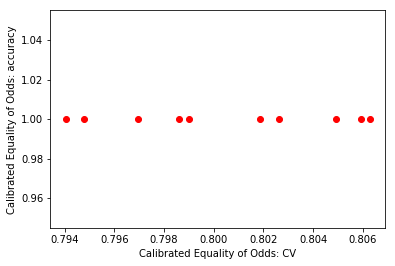

In [23]:
plt.plot(list(adult_calibratedEqualityOdds_CV.values()), list(adult_calibratedEqualityOdds_accuracy.values()), 'ro')
plt.ylabel('Calibrated Equality of Odds: accuracy')
plt.xlabel('Calibrated Equality of Odds: CV')
plt.show()

In [24]:
# # from matplotlib import pyplot as plt 

# #generate a list of markers and another of colors 
# markers = ["." , "," , "o" , "v" , "^" , "<", ">", "+", "x", "s"]
# colors = ['r','g','b','c','m', 'y', 'k', 'black', 'lightcoral', 'darkorchid', '']

# #make a sample dataset
# x = np.arange(0,11)  #test x values.. every feature gets the same x values but you can generalize this
# y = [s*x for s in np.arange(10)] #generate 7 arrays of y values 


# for i in range(0,11): #for each of the 7 features 
#     mi = markers[i] #marker for ith feature 
#     xi = x #x array for ith feature .. here is where you would generalize      different x for every feature
#     yi = y[i] #y array for ith feature 
#     ci = colors[i] #color for ith feature 
# #     plt.scatter(xi,yi,marker=mi, color=ci) 
# # plt.show() 

## Random Forest

### We performed the above the algos with Logistic Regression. Let's Try with Random Forest as well

#### Right now we have taken random values for estimators and minsampleleaf, for demo purposes.

In [25]:
nestimators = 500
minsamplesleaf = 25

In [26]:
dataset_orig_test_transf_pred = {}
adult_disparateImpactRemover_disparate_impact = {}
adult_disparateImpactRemover_accuracy = {}
adult_disparateImpactRemover_CV = {}



for i in range(0, 10):
    X_tr = np.delete(dataset_orig_train_transf[i].features, index, axis=1)
    X_te = np.delete(dataset_orig_test_transf[i].features, index, axis=1)
    y_tr = dataset_orig_train_transf[i].labels.ravel()
    
#     lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
#     lmod.fit(X_tr, y_tr)
    rfmod = RandomForestClassifier(n_estimators = nestimators, min_samples_leaf = minsamplesleaf)
    rfmod.fit(X_tr, y_tr)
    
    dataset_orig_test_transf_pred[i] = dataset_orig_test_transf[i].copy()
    dataset_orig_test_transf_pred[i].labels = rfmod.predict(X_te)
    
    
    metric_otr_classification = ClassificationMetric(dataset_orig_test_transf[i], dataset_orig_test_transf_pred[i], unprivileged_groups=unpriv, privileged_groups=priv)
    
    adult_disparateImpactRemover_disparate_impact[i] = metric_otr_classification.disparate_impact()
    adult_disparateImpactRemover_accuracy[i] = metric_otr_classification.accuracy()
    adult_disparateImpactRemover_CV[i] = 1 - (-(metric_otr_classification.statistical_parity_difference()))


#### Now we can plot to see how the trade-off between fairness and accuracy changes when we use different input splits
#### For fairness we are using CV measure and for accuracy we are using the generic accuracy measure

Goal 1

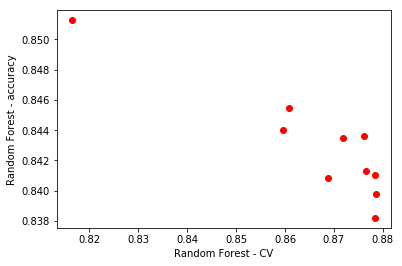

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(list(adult_disparateImpactRemover_CV.values()), list(adult_disparateImpactRemover_accuracy.values()), 'ro')
plt.ylabel('Random Forest - accuracy')
plt.xlabel('Random Forest - CV')
plt.show()

### Automate the search for best repair level value in Disparate Impact Remover

Goal 4

In [28]:
# Create the algorithm object
# repair_level=1.0 means we want to maximise fairness.
# di = DisparateImpactRemover(repair_level=1.0)
di = {}
repair_level = [0.0, 0.25, 0.5, 0.75, 1.0]
for i in range(len(repair_level)):
    di[i] = DisparateImpactRemover(repair_level=repair_level[i])

In [29]:
dataset_orig_train_transf_automate = {}
dataset_orig_test_transf_automate = {}

dataset_orig_test_transf_pred_automate = {}
adult_disparateImpactRemover_disparate_impact_automate = {}
adult_disparateImpactRemover_accuracy_automate = {}
adult_disparateImpactRemover_CV_automate = {}

pos = 0

for j in range(len(repair_level)):
    for i in range(0,10):
        dataset_orig_train_transf_automate[pos] = di[j].fit_transform(dataset_orig_train[i])
        dataset_orig_test_transf_automate[pos] = di[j].fit_transform(dataset_orig_test[i])
        
        X_tr = np.delete(dataset_orig_train_transf_automate[pos].features, index, axis=1)
        X_te = np.delete(dataset_orig_test_transf_automate[pos].features, index, axis=1)
        y_tr = dataset_orig_train_transf_automate[pos].labels.ravel()

        lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
        lmod.fit(X_tr, y_tr)

        dataset_orig_test_transf_pred_automate[pos] = dataset_orig_test_transf_automate[pos].copy()
        dataset_orig_test_transf_pred_automate[pos].labels = lmod.predict(X_te)


        metric_otr_classification = ClassificationMetric(dataset_orig_test_transf_automate[pos], dataset_orig_test_transf_pred_automate[pos], unprivileged_groups=unpriv, privileged_groups=priv)

        adult_disparateImpactRemover_disparate_impact_automate[pos] = metric_otr_classification.disparate_impact()
        adult_disparateImpactRemover_accuracy_automate[pos] = metric_otr_classification.accuracy()
        adult_disparateImpactRemover_CV_automate[pos] = 1 - (-(metric_otr_classification.statistical_parity_difference()))
        
        pos += 1

#### Now we can plot to see how the trade-off between fairness and accuracy changes when we use different input splits
#### For fairness we are using CV measure and for accuracy we are using the generic accuracy measure

In [33]:
g1_CV = (list(adult_disparateImpactRemover_CV_automate.values())[:11], list(adult_disparateImpactRemover_accuracy_automate.values())[:11])
g2_CV = (list(adult_disparateImpactRemover_CV_automate.values())[11:21], list(adult_disparateImpactRemover_accuracy_automate.values())[11:21])

g3_CV = (list(adult_disparateImpactRemover_CV_automate.values())[22:32], list(adult_disparateImpactRemover_accuracy_automate.values())[22:32])

g4_CV = (list(adult_disparateImpactRemover_CV_automate.values())[33:43], list(adult_disparateImpactRemover_accuracy_automate.values())[33:43])

g5_CV = (list(adult_disparateImpactRemover_CV_automate.values())[44:], list(adult_disparateImpactRemover_accuracy_automate.values())[44:])



In [30]:
g1 = (list(adult_disparateImpactRemover_disparate_impact_automate.values())[:11], list(adult_disparateImpactRemover_accuracy_automate.values())[:11])
g2 = (list(adult_disparateImpactRemover_disparate_impact_automate.values())[11:21], list(adult_disparateImpactRemover_accuracy_automate.values())[11:21])

g3 = (list(adult_disparateImpactRemover_disparate_impact_automate.values())[22:32], list(adult_disparateImpactRemover_accuracy_automate.values())[22:32])

g4 = (list(adult_disparateImpactRemover_disparate_impact_automate.values())[33:43], list(adult_disparateImpactRemover_accuracy_automate.values())[33:43])

g5 = (list(adult_disparateImpactRemover_disparate_impact_automate.values())[44:], list(adult_disparateImpactRemover_accuracy_automate.values())[44:])



In [31]:
groups = {"0.0" : g1, "0.25" : g2, "0.5" : g3, "0.75" : g4, "1.0" : g5}

In [34]:
groups_CV = {"0.0" : g1_CV, "0.25" : g2_CV, "0.5" : g3_CV, "0.75" : g4_CV, "1.0" : g5_CV}

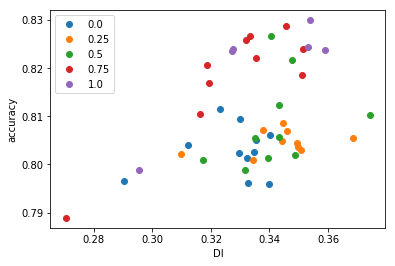

In [32]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups.items():
    ax.plot(group[0], group[1], marker='.', linestyle='', ms=12, label=name)
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('DI')
plt.show()

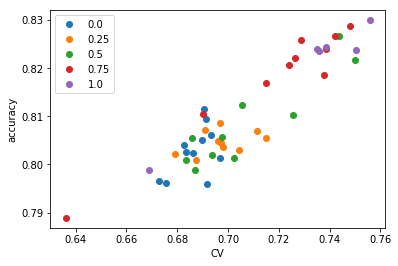

In [35]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups_CV.items():
    ax.plot(group[0], group[1], marker='.', linestyle='', ms=12, label=name)
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('CV')
plt.show()

## Trying another dataset - Compas

In [36]:
## import dataset
dataset_used = "compas" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
    dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 0}]
        unprivileged_groups = [{'sex': 1}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]  
        dataset_orig = load_preproc_data_compas(['race'])

        

#### In Compas dataset, female: 1 and male: 0
#### female is the priviledged class

In [37]:
# dataset_orig_adult = dataset_orig = AdultDataset(protected_attribute_names=['sex'], privileged_classes=[['Male']], features_to_drop=['fnlwgt','race'])


# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig.favorable_label, dataset_orig.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig.privileged_protected_attributes, dataset_orig.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig.feature_names)


#### Dataset shape

(5278, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [38]:
# dataset_orig_train, dataset_orig_test = dataset_orig_adult.split([0.7], shuffle=True)
dataset_orig_train = {}
dataset_orig_test = {}

for i in range(0,10):
    dataset_orig_train[i], dataset_orig_test[i] = dataset_orig.split([0.7], shuffle=True)
    

#### Test for disparate impact values for each train split

In [39]:
# Define privileged and unprivileged groups
priv = [{'sex': 1}] # Female
unpriv = [{'sex': 0}] # Male

In [40]:
for i in range(0,10):
    metric_otr = BinaryLabelDatasetMetric( dataset_orig_train[i],
    unprivileged_groups=unpriv, privileged_groups=priv)
    
    print("Disparate Impact value for original train split {} is: ".format(i), metric_otr.disparate_impact())

Disparate Impact value for original train split 0 is:  0.7988274896819688
Disparate Impact value for original train split 1 is:  0.7809304599635557
Disparate Impact value for original train split 2 is:  0.7992958399925173
Disparate Impact value for original train split 3 is:  0.774783827128739
Disparate Impact value for original train split 4 is:  0.7729551440484014
Disparate Impact value for original train split 5 is:  0.8081784319398236
Disparate Impact value for original train split 6 is:  0.7920987124622264
Disparate Impact value for original train split 7 is:  0.7657945501050256
Disparate Impact value for original train split 8 is:  0.8061551184358202
Disparate Impact value for original train split 9 is:  0.7989313074244687


In [41]:
for i in range(0,10):
    metric_otr = BinaryLabelDatasetMetric( dataset_orig_test[i],
    unprivileged_groups=unpriv, privileged_groups=priv)
    
    print("Disparate Impact value for original test split {} is: ".format(i), metric_otr.disparate_impact())

Disparate Impact value for original test split 0 is:  0.765694799658994
Disparate Impact value for original test split 1 is:  0.8062566654816921
Disparate Impact value for original test split 2 is:  0.7627329192546585
Disparate Impact value for original test split 3 is:  0.8208001918541907
Disparate Impact value for original test split 4 is:  0.8241335044929397
Disparate Impact value for original test split 5 is:  0.7469196740050175
Disparate Impact value for original test split 6 is:  0.7800237812128419
Disparate Impact value for original test split 7 is:  0.8450279161007996
Disparate Impact value for original test split 8 is:  0.7485947106848508
Disparate Impact value for original test split 9 is:  0.7647599197159178


#### Now we will use DiparateImpactRemover Algo to mitigate this bias

In [43]:
# Create the algorithm object
# repair_level=1.0 means we want to maximise fairness.
di = DisparateImpactRemover(repair_level=1.0)

In [44]:
dataset_orig_train_transf = {}
dataset_orig_test_transf = {}

for i in range(0,10):
    dataset_orig_train_transf[i] = di.fit_transform(dataset_orig_train[i])
    dataset_orig_test_transf[i] = di.fit_transform(dataset_orig_test[i])

#### Now we will fit a Logistic Regression Classifier to this repaired dataset and obtain predictions 

In [45]:
protected = 'sex'
index = dataset_orig_train_transf[0].feature_names.index(protected)

In [46]:
dataset_orig_test_transf_pred = {}
compas_disparateImpactRemover_disparate_impact = {}
compas_disparateImpactRemover_accuracy = {}
compas_disparateImpactRemover_CV = {}


for i in range(0, 10):
    X_tr = np.delete(dataset_orig_train_transf[i].features, index, axis=1)
    X_te = np.delete(dataset_orig_test_transf[i].features, index, axis=1)
    y_tr = dataset_orig_train_transf[i].labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    dataset_orig_test_transf_pred[i] = dataset_orig_test_transf[i].copy()
    dataset_orig_test_transf_pred[i].labels = lmod.predict(X_te)
    
    
    metric_otr_classification = ClassificationMetric(dataset_orig_test_transf[i], dataset_orig_test_transf_pred[i], unprivileged_groups=unpriv, privileged_groups=priv)
    
    compas_disparateImpactRemover_disparate_impact[i] = metric_otr_classification.disparate_impact()
    compas_disparateImpactRemover_accuracy[i] = metric_otr_classification.accuracy()
    compas_disparateImpactRemover_CV[i] = 1 - (-(metric_otr_classification.statistical_parity_difference()))


#### Now we can plot to see how the trade-off between fairness and accuracy changes when we use different input splits
#### For fairness we are using CV measure and for accuracy we are using the generic accuracy measure

Goal 1

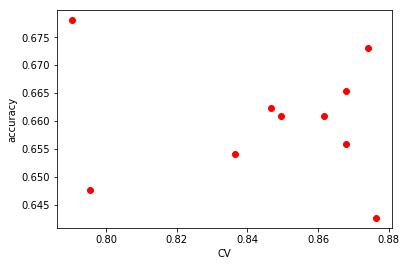

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(list(compas_disparateImpactRemover_CV.values()), list(compas_disparateImpactRemover_accuracy.values()), 'ro')
plt.ylabel('accuracy')
plt.xlabel('CV')
plt.show()

#### we can see that the repaired test pred dataset DI values did change when compared to the original test dataset

In [62]:
compas_disparateImpactRemover_disparate_impact

{0: 0.8003861236802413,
 1: 0.7965517241379311,
 2: 0.7560236998025016,
 3: 0.7041329511230451,
 4: 0.7699805068226121,
 5: 0.7044003090423232,
 6: 0.8008378988076056,
 7: 0.7887820858984051,
 8: 0.762503658353306,
 9: 0.8032295455453855}

## German Dataset

In [48]:
## import dataset
dataset_used = "german" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
    dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 0}]
        unprivileged_groups = [{'sex': 1}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]  
        dataset_orig = load_preproc_data_compas(['race'])

        

#### In german dataset: Male is 1, Female: 0
#### Male is the priviledged class

In [49]:
# dataset_orig_adult = dataset_orig = AdultDataset(protected_attribute_names=['sex'], privileged_classes=[['Male']], features_to_drop=['fnlwgt','race'])


# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig.favorable_label, dataset_orig.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig.privileged_protected_attributes, dataset_orig.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig.feature_names)


#### Dataset shape

(1000, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [50]:
# dataset_orig_train, dataset_orig_test = dataset_orig_adult.split([0.7], shuffle=True)
dataset_orig_train = {}
dataset_orig_test = {}

for i in range(0,10):
    dataset_orig_train[i], dataset_orig_test[i] = dataset_orig.split([0.7], shuffle=True)
    

#### Test for disparate impact values for each train split

In [51]:
# Define privileged and unprivileged groups
priv = [{'sex': 1}] # Male
unpriv = [{'sex': 0}] # Female

In [52]:
for i in range(0,10):
    metric_otr = BinaryLabelDatasetMetric( dataset_orig_train[i],
    unprivileged_groups=unpriv, privileged_groups=priv)
    
    print("Disparate Impact value for original train split {} is: ".format(i), metric_otr.disparate_impact())

Disparate Impact value for original train split 0 is:  0.9110141124173204
Disparate Impact value for original train split 1 is:  0.9066316236593394
Disparate Impact value for original train split 2 is:  0.9166853687837463
Disparate Impact value for original train split 3 is:  0.8772765443762137
Disparate Impact value for original train split 4 is:  0.9219413549039434
Disparate Impact value for original train split 5 is:  0.9049672300793377
Disparate Impact value for original train split 6 is:  0.9580820770519263
Disparate Impact value for original train split 7 is:  0.8885233918128654
Disparate Impact value for original train split 8 is:  0.8712273895299038
Disparate Impact value for original train split 9 is:  0.9069155115000388


In [53]:
for i in range(0,10):
    metric_otr = BinaryLabelDatasetMetric( dataset_orig_test[i],
    unprivileged_groups=unpriv, privileged_groups=priv)
    
    print("Disparate Impact value for original test split {} is: ".format(i), metric_otr.disparate_impact())

Disparate Impact value for original test split 0 is:  0.8641666666666665
Disparate Impact value for original test split 1 is:  0.8742289968096421
Disparate Impact value for original test split 2 is:  0.8556277056277055
Disparate Impact value for original test split 3 is:  0.9430172476530093
Disparate Impact value for original test split 4 is:  0.8407382091592618
Disparate Impact value for original test split 5 is:  0.8819875776397514
Disparate Impact value for original test split 6 is:  0.7839782228271437
Disparate Impact value for original test split 7 is:  0.9192712190786549
Disparate Impact value for original test split 8 is:  0.9587653725584759
Disparate Impact value for original test split 9 is:  0.8672727272727273


#### Now we will use DiparateImpactRemover Algo to mitigate this bias

In [54]:
# Create the algorithm object
# repair_level=1.0 means we want to maximise fairness.
di = DisparateImpactRemover(repair_level=1.0)

In [55]:
dataset_orig_train_transf = {}
dataset_orig_test_transf = {}

for i in range(0,10):
    dataset_orig_train_transf[i] = di.fit_transform(dataset_orig_train[i])
    dataset_orig_test_transf[i] = di.fit_transform(dataset_orig_test[i])

#### Now we will fit a Logistic Regression Classifier to this training dataset and obtain predictions on the test datasets


In [57]:
protected = 'sex'
index = dataset_orig_train_transf[0].feature_names.index(protected)

In [59]:
dataset_orig_test_transf_pred = {}
german_disparateImpactRemover_disparate_impact = {}
german_disparateImpactRemover_accuracy = {}
german_disparateImpactRemover_CV = {}


for i in range(0, 10):
    X_tr = np.delete(dataset_orig_train_transf[i].features, index, axis=1)
    X_te = np.delete(dataset_orig_test_transf[i].features, index, axis=1)
    y_tr = dataset_orig_train_transf[i].labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    dataset_orig_test_transf_pred[i] = dataset_orig_test_transf[i].copy()
    dataset_orig_test_transf_pred[i].labels = lmod.predict(X_te)
    
    
    metric_otr_classification = ClassificationMetric(dataset_orig_test_transf[i], dataset_orig_test_transf_pred[i], unprivileged_groups=unpriv, privileged_groups=priv)
    
    german_disparateImpactRemover_disparate_impact[i] = metric_otr_classification.disparate_impact()
    german_disparateImpactRemover_accuracy[i] = metric_otr_classification.accuracy()
    german_disparateImpactRemover_CV[i] = 1 - (-(metric_otr_classification.statistical_parity_difference()))


#### Now we can plot to see how the trade-off between fairness and accuracy changes when we use different input splits
#### For fairness we are using CV measure and for accuracy we are using the generic accuracy measure

Goal 1

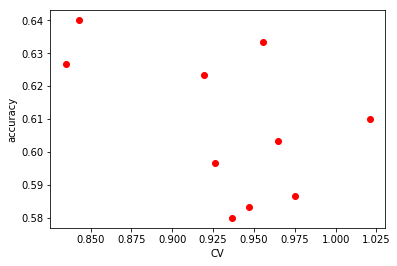

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(list(german_disparateImpactRemover_CV.values()), list(german_disparateImpactRemover_accuracy.values()), 'ro')
plt.ylabel('accuracy')
plt.xlabel('CV')
plt.show()

#### we can see that the repaired test pred dataset DI values did change when compared to the original test dataset

In [61]:
german_disparateImpactRemover_disparate_impact

{0: 0.9417613636363635,
 1: 0.8851877289377289,
 2: 0.8459595959595959,
 3: 0.8483318483318484,
 4: 0.9129554655870445,
 5: 0.6964922711058263,
 6: 0.8698589894242069,
 7: 1.0451162790697675,
 8: 0.9270170739872783,
 9: 0.7227272727272728}